In [8]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import csv
import os

In [136]:
class wsj_data():
    def __init__(self, wsj_path):
        self.wsj_path = wsj_path
        self.dev_set = None
        self.train_set = None
        self.test_set = None

    @property
    def dev(self):
        if self.dev_set is None:
            self.dev_set = self.load('dev')
        return self.dev_set

    @property
    def train(self):
        if self.train_set is None:
            self.train_set = self.load('train')
        return self.train_set

    @property
    def test(self):
        if self.test_set is None:
            self.test_set = np.load(os.path.join(self.wsj_path, '{}.npy'.format('test')), encoding='bytes', allow_pickle=True)
        return (self.test_set, )

    def load(self, name):
        return (
            np.load(self.wsj_path+'/{}.npy'.format(name), encoding='bytes', allow_pickle=True),
            np.load(self.wsj_path+'/{}_labels.npy'.format(name), encoding='bytes', allow_pickle=True)
        )

In [10]:
class WsjDataset(torch.utils.data.Dataset):
    def __init__(self, wsj, k=10):

        self.x_list = wsj[0]
        self.y_list = wsj[1] if len(wsj) == 2 else None
        self.idx_map = []
        self.k = k

        for i, xs in enumerate(self.x_list):
            for j in range(xs.shape[0]):
                self.idx_map.append((i, j))

    def __getitem__(self, idx):
        i, j = self.idx_map[idx]
        win = self.x_list[i].take(range(j - self.k, j + self.k + 1), mode='clip', axis=0).flatten()
        xi = torch.from_numpy(win).float()
        yi = self.y_list[i][j] if self.y_list is not None else -1
        return xi, yi

    def __len__(self):
        return len(self.idx_map)

In [127]:
for batch_idx, (data, target) in enumerate(test_loader):
    if batch_idx <= 10:
        print(data.shape)
        print(data[0][0].shape)

torch.Size([256, 21])
torch.Size([])
torch.Size([256, 21])
torch.Size([])
torch.Size([256, 21])
torch.Size([])
torch.Size([256, 21])
torch.Size([])
torch.Size([256, 21])
torch.Size([])
torch.Size([256, 21])
torch.Size([])
torch.Size([256, 21])
torch.Size([])
torch.Size([256, 21])
torch.Size([])
torch.Size([256, 21])
torch.Size([])
torch.Size([256, 21])
torch.Size([])
torch.Size([256, 21])
torch.Size([])


In [ ]:
# Unit Test for WsjDataset Class
test_wsj_dataset = WsjDataset(wsj_loader.dev)
xi, yi = test_wsj_dataset.__getitem()__
print(xi.shape, yi.shape)
print
print("the current frame data = " xi[400:441])
print("the label = " yi)

In [52]:
for batch, (data,target) in enumerate(training_loader):
    print((data.shape,  target.shape))
    if batch == 10:
        break

(torch.Size([256, 840]), torch.Size([256]))
(torch.Size([256, 840]), torch.Size([256]))
(torch.Size([256, 840]), torch.Size([256]))
(torch.Size([256, 840]), torch.Size([256]))
(torch.Size([256, 840]), torch.Size([256]))
(torch.Size([256, 840]), torch.Size([256]))
(torch.Size([256, 840]), torch.Size([256]))
(torch.Size([256, 840]), torch.Size([256]))
(torch.Size([256, 840]), torch.Size([256]))
(torch.Size([256, 840]), torch.Size([256]))
(torch.Size([256, 840]), torch.Size([256]))


In [137]:
wsj_loader = wsj_data('./data')
kwargs = {'num_workers': 8, 'pin_memory': True}

training_loader = torch.utils.data.DataLoader(WsjDataset(wsj_loader.train),
                                              batch_size=256,
                                              shuffle=True,
                                              **kwargs)
eval_loader = torch.utils.data.DataLoader(WsjDataset(wsj_loader.dev),
                                          batch_size=256,
                                          shuffle=True,
                                          **kwargs)
test_loader = torch.utils.data.DataLoader(WsjDataset(wsj_loader.test),
                                          batch_size=256,
                                          shuffle=False,
                                          **kwargs)

In [57]:
in_size = 840
out_size=138
hidden = [1024, 1024, 1024, 1024, 1024]

class WSJModel(nn.Module):
    def __init__(self):
        super(WSJModel, self).__init__()
        self.fc1 = nn.Linear(in_size, hidden[0])
        self.bn1 = nn.BatchNorm1d(hidden[0])
        self.fc2 = nn.Linear(hidden[0], hidden[1])
        self.bn2 = nn.BatchNorm1d(hidden[1])
        self.fc3 = nn.Linear(hidden[1], hidden[2])
        self.bn3 = nn.BatchNorm1d(hidden[2])
        self.fc4 = nn.Linear(hidden[2], hidden[3])
        self.bn4 = nn.BatchNorm1d(hidden[3])
        self.fc5 = nn.Linear(hidden[3], hidden[4])
#         self.bn5 = nn.BatchNorm1d(hidden[4])
        self.fc5 = nn.Linear(hidden[4], out_size)
#         self.bn5 = nn.BatchNorm1d(out_size)
    
    def forward(self, x):
        x = F.relu(self.bn1(self.fc1(x)))
        x = F.relu(self.bn2(self.fc2(x)))
        x = F.relu(self.bn3(self.fc3(x)))
        x = F.relu(self.bn4(self.fc4(x)))
        x = self.fc5(x)
        return x
    
print(WSJModel())

WSJModel(
  (fc1): Linear(in_features=840, out_features=1024, bias=True)
  (bn1): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=1024, out_features=1024, bias=True)
  (bn2): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc3): Linear(in_features=1024, out_features=1024, bias=True)
  (bn3): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc4): Linear(in_features=1024, out_features=1024, bias=True)
  (bn4): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc5): Linear(in_features=1024, out_features=138, bias=True)
  (bn5): BatchNorm1d(138, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)


In [89]:
def inference(model, loader):
    correct = 0
    model.eval()
    n_members = 0
    for data, label in loader:
        X = data.cuda()
        Y = label.cuda()
        out = model(X)
        pred = out.data.max(1, keepdim=True)[1]
        predicted = pred.eq(Y.data.view_as(pred))
        correct += predicted.sum()
        # overall data
        n_members += predicted.size()[0]
    return correct.cpu().numpy() / n_members

In [140]:
def final_test(model, loader, filename):
    print('start')
    for i, (data, label) in enumerate(loader):
        data = data.cuda()
        out = model(data)
        pred = out.data.max(1, keepdim=True)[1].cpu().numpy()
        if i == 0:
            test_result = pred
        else:
            test_result = np.concatenate((test_result, pred), axis=0)
    test_result_index = np.arange(test_result.shape[0]).reshape((test_result.shape[0], 1))
    test_result = np.concatenate((test_result_index, test_result), axis=1)
    np.savetxt(filename + '.csv', test_result, delimiter=',', fmt='%d', header='id,label')
    print("finish the csv prediction file")

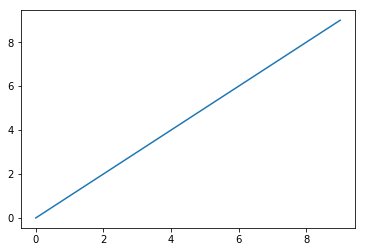

In [93]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(np.arange(10))

hahahah


/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/ipykernel_launcher.py:24: RuntimeWarning: divide by zero encountered in true_divide


epoch: 1, batch: 0, correctness: inf, loss: 1.576
epoch: 1, batch: 5000, correctness: 0.626, loss: 1.308
epoch: 1, batch: 10000, correctness: 0.625, loss: 1.676
epoch: 1, batch: 15000, correctness: 0.625, loss: 1.463
epoch: 1, batch: 20000, correctness: 0.625, loss: 1.590
epoch: 1, batch: 25000, correctness: 0.625, loss: 1.505
epoch: 1, batch: 30000, correctness: 0.625, loss: 1.286
epoch: 1, batch: 35000, correctness: 0.625, loss: 1.509
epoch: 1, batch: 40000, correctness: 0.625, loss: 1.563
epoch: 1, batch: 45000, correctness: 0.625, loss: 1.305
epoch: 1, batch: 50000, correctness: 0.626, loss: 1.418
epoch: 1, batch: 55000, correctness: 0.626, loss: 1.499
epoch: 1, batch: 60000, correctness: 0.626, loss: 1.243


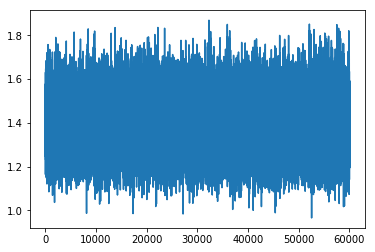

Ephoch:1 end
epoch: 1, loss: 1.394, train_acc: 0.626, val_acc: 0.616
epoch: 2, batch: 0, correctness: inf, loss: 1.385
epoch: 2, batch: 5000, correctness: 0.626, loss: 1.424


KeyboardInterrupt: 

In [111]:
print('hahahah')
n_epochs = 8
my_model = WSJModel()
my_model.load_state_dict(torch.load('./no_bn_model.pt'))
my_model.cuda()
SGDOptimizer = torch.optim.SGD(my_model.parameters(), lr=0.001)
ADAMOptimizer = torch.optim.Adam(my_model.parameters(), lr=0.00001)
loss_list = []

for e in range(n_epochs):
    loss_denominate = 0
    my_model.train()
    epoch_loss = 0
    correct = 0
    for batch_idx, (data, label) in enumerate(training_loader):
        SGDOptimizer.zero_grad()
        data = data.cuda()
        label = label.cuda()
        out = my_model(data)
        
        pred = out.data.max(1, keepdim=True)[1]
        predicted = pred.eq(label.data.view_as(pred))
        correct += predicted.sum()
        correctness =  correct.cpu().detach().numpy()/ (batch_idx * 256)
        
        loss = F.cross_entropy(out, label)
        loss_denominate += 1
        
        print_loss = loss.cpu().detach().numpy()
        loss_list.append(print_loss)
        loss.backward()

        SGDOptimizer.step()
        epoch_loss += loss.item()

        if batch_idx % 5000 == 0:
            print("epoch: {0}, batch: {1}, correctness: {2:.3f}, loss: {3:.3f}".format(e + 1, batch_idx, correctness, print_loss))
    
    torch.save(my_model.state_dict(), './no_bn_model.pt')
    plt.figure()
    plt.plot(loss_list)
    plt.show()
    total_loss = epoch_loss / loss_denominate

    train_acc = correct.cpu().detach().numpy() / (loss_denominate * 256)
    val_acc = inference(my_model, eval_loader)
    print("Ephoch:{0} end".format(e + 1))
    print("epoch: {0}, loss: {1:.3f}, train_acc: {2:.3f}, val_acc: {3:.3f}".format(e + 1, total_loss, train_acc, val_acc))
    

In [128]:
my_model = WSJModel()
my_model.load_state_dict(torch.load('./no_bn_model.pt'))
my_model.cuda()
val_acc = inference(my_model, eval_loader)
print(val_acc)

0.6155369054030859


In [141]:
final_test(my_model, test_loader,'6.1024output')

start
finish the csv prediction file
